In [1]:
import os
import glob
import time
import numpy as np
import pandas as pd
import seaborn as sn
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from joblib import dump, load
from os import path
from tensorflow import keras
from keras import layers, models, callbacks, optimizers
from matplotlib.pyplot import *
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, Flatten, Convolution1D, UpSampling1D, MaxPooling1D
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, multilabel_confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

c:\Users\ADMIN\anaconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# python.exe -m pip install --upgrade pip

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# full dataset
path = r'C:/Users/ADMIN/Desktop/code_folders/Capstone_Project/CIC-IDS/CSV-2023/MERGED_CSV'
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, encoding='cp1252', index_col=None, header=0)
    li.append(df)
    print("Read Completed for ", filename)
df = pd.concat(li, axis=0, ignore_index=True)
df.describe()
df.head()
df.info()

Read Completed for  C:/Users/ADMIN/Desktop/code_folders/Capstone_Project/CIC-IDS/CSV-2023/MERGED_CSV\Merged01.csv
Read Completed for  C:/Users/ADMIN/Desktop/code_folders/Capstone_Project/CIC-IDS/CSV-2023/MERGED_CSV\Merged02.csv


KeyboardInterrupt: 

In [ ]:
print(df.columns)
print(df["Label"].value_counts())
print(df.shape)

Index(['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max',
       'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label'],
      dtype='object')
Label
DDOS-ICMP_FLOOD            6893259
DDOS-UDP_FLOOD             5181027
DDOS-TCP_FLOOD             4306086
DDOS-PSHACK_FLOOD          3920372
DDOS-SYN_FLOOD             3886130
DDOS-RSTFINFLOOD           3872808
DDOS-SYNONYMOUSIP_FLOOD    3445659
DOS-UDP_FLOOD              3177323
DOS-TCP_FLOOD              2558256
DOS-SYN_FLOOD              1942176
BENIGN                     1051373
MIRAI-GREETH_FLOOD          949381
MIRAI-UDPPLAIN              852695
MIRAI-GREIP_FLOOD   

Many network intrusion datasets (like CICIoT2023) contain very specific attack names (e.g., 'DDoS-UDP_Flood', 'SqlInjection'). These are too granular for efficient model training and analysis, so we group them into broader categories, such as 'DDoS', 'DoS', 'Recon', etc.

<h3> Why this is useful </h3>
    <li> Reduces label complexity (from 30+ labels to ~6–7 categories).</li>
    <li> Helps balance the dataset more evenly.</li>
    <li> Simplifies the classification problem for your ML model.</li>

<h3> Example: </h3>
<p>If your original data had this:</p>
<P>Label</p>
<ul>
    <li>DDoS-UDP_Flood</li>
    <li>DDoS-ACK_Fragmentation</li>
    <li>SqlInjection</li>
</ul>

<p>It will become:</p>
<p>Label</p>
<ul>
    <li>DDoS</li>
    <li>DDoS</li>
    <li>Web_based</li>
</ul>

In [ ]:
DDoS = ['DDoS-ACK_Fragmentation',     
        'DDoS-UDP_Flood',       
        'DDoS-SlowLoris',               
        'DDoS-ICMP_Flood',        
        'DDoS-RSTFIN_Flood',    
        'DDoS-PSHACK_Flood',        
        'DDoS-HTTP_Flood',              
        'DDoS-UDP_Fragmentation',     
        'DDoS-TCP_Flood',  
        'DDoS-SYN_Flood',        
        'DDoS-SynonymousIP_Flood',    
        'DDoS-ICMP_Fragmentation']

DoS = ['DoS-UDP_Flood',    
       'DoS-TCP_Flood',    
       'DoS-SYN_Flood',    
       'DoS-HTTP_Flood']

Spoofing = ['MITM-ArpSpoofing',     
            'DNS_Spoofing']

Brute_force = ['DictionaryBruteForce']

Recon = ['Recon-HostDiscovery', 
         'Recon-OSScan',     
         'Recon-PortScan',               
         'Recon-PingSweep',         
         'VulnerabilityScan']

Web_based = ['SqlInjection',        
             'BrowserHijacking',         
             'CommandInjection',       
             'XSS',         
             'Backdoor_Malware',          
             'Uploading_Attack']

Mirai = ['Mirai-greeth_flood',     
         'Mirai-udpplain',     
         'Mirai-greip_flood']



def classify_attacks(data):
    data['Label'].replace(DDoS,'DDoS',inplace=True)
    data['Label'].replace(DoS,'DoS',inplace=True)
    data['Label'].replace(Spoofing,'Spoofing',inplace=True)
    data['Label'].replace(Brute_force,'Brute_Force',inplace=True)
    data['Label'].replace(Recon,'Recon',inplace=True)
    data['Label'].replace(Web_based,'Web_based',inplace=True)
    data['Label'].replace(Mirai,'Mirai',inplace=True)
classify_attacks(df)

print(df["Label"].value_counts())
print(df.shape)

Label
DDOS-ICMP_FLOOD            6893259
DDOS-UDP_FLOOD             5181027
DDOS-TCP_FLOOD             4306086
DDOS-PSHACK_FLOOD          3920372
DDOS-SYN_FLOOD             3886130
DDOS-RSTFINFLOOD           3872808
DDOS-SYNONYMOUSIP_FLOOD    3445659
DOS-UDP_FLOOD              3177323
DOS-TCP_FLOOD              2558256
DOS-SYN_FLOOD              1942176
BENIGN                     1051373
MIRAI-GREETH_FLOOD          949381
MIRAI-UDPPLAIN              852695
MIRAI-GREIP_FLOOD           719655
DDOS-ICMP_FRAGMENTATION     433157
VULNERABILITYSCAN           357583
MITM-ARPSPOOFING            294469
DDOS-UDP_FRAGMENTATION      274909
DDOS-ACK_FRAGMENTATION      272793
DNS_SPOOFING                171468
RECON-HOSTDISCOVERY         128677
RECON-OSSCAN                 93970
RECON-PORTSCAN               78730
DOS-HTTP_FLOOD               68799
DDOS-HTTP_FLOOD              27597
DDOS-SLOWLORIS               22400
DICTIONARYBRUTEFORCE         12522
BROWSERHIJACKING              5630
COMMANDINJECTI

In [ ]:
data_clean = df.dropna().reset_index(drop=True)
data_clean.drop_duplicates(keep='first', inplace = True)
data_clean['Label'].value_counts()
print("Read {} rows.".format(len(data_clean)))

data_clean.columns          # This just lists the column names in the data_clean DataFrame—helpful for debugging or inspection.
data_clean = data_clean.dropna().reset_index()    # dropna() removes any rows that contain NaN (missing) values; reset_index() resets the row index after dropping, so it's clean and continuous.
labelencoder = LabelEncoder()    # This creates a LabelEncoder from sklearn, which is used to convert string labels into integers
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])    # Encodes the string class labels into integer labels and replaces the original Label column with them.
data_clean['Label'].value_counts()     # Shows how many samples exist for each class (now as numbers). This is useful to check for class imbalance.
print(data_clean.shape)
print(data_clean['Label'].value_counts())

data_np = data_clean.to_numpy(dtype="float32")      # Converts the entire DataFrame into a NumPy array with float32 data type—faster and more efficient for ML model input.
#drop inf values
data_np = data_np[~np.isinf(data_np).any(axis=1)]   # Removes any rows that have infinite values (inf) across any column. This ensures clean numeric data for training

Read 45018564 rows.
(45018564, 42)
Label
6     6893203
14    5180997
13    4306058
8     3920337
12    3886105
9     3872787
11    3445630
21    3177280
20    2558232
19    1942159
1     1051313
22     949325
24     852632
23     719604
7      433115
32     357579
25     294451
15     274881
4      272767
17     171463
26     128676
27      93966
29      78729
18      68798
5       27597
10      22399
16      12522
2        5630
3        5168
30       5021
33       3705
0        3078
28       2161
31       1196
Name: count, dtype: int64


In [ ]:
rows = data_np.shape[0]
limit = round(rows*50/100) # split the dataset into 2 part: 80% for train and val; 20% to test
train_val = data_np[1:limit] 	

test = data_np[limit:rows]

In [ ]:
print(train_val.shape)

(22509121, 42)


In [ ]:
X = train_val[:, :-1]       # This selects all features (columns except the last one)—i.e., your input data for the model.
enc = OneHotEncoder()     # Initializes a OneHotEncoder which is used to encode integer class labels into one-hot encoded vectors.
                          # For example: if i have [0, 1, 2], One-hot encoding becomes: [1,0,0]
                                                                                       #[0,1,0]
                                                                                       #[0,0,1]
Y = enc.fit_transform(train_val[:, -1].reshape(-1, 1)).toarray()      # data_np[:, -1] gets the last column = labels (in integer form).
                                                                    # reshape(-1, 1) reshapes it into a column vector.
                                                                    # fit_transform(...) fits and transforms to one-hot encoded format.
                                                                    # .toarray() converts it from sparse to dense array.

                                                                    # Now Y contains labels in one-hot format, ready for training in multiclass classification models like neural networks.
#  Final Result:
#   X: Cleaned, scaled feature matrix.
#   Y: One-hot encoded label matrix.
#Ready to be split into training/testing and fed into models like CNN, LSTM, etc.

In [ ]:
X_test = test[:, :-1] 
enc = OneHotEncoder()

Y_test = enc.fit_transform(test[:, -1].reshape(-1, 1)).toarray()
# print(X_test)
# print(Y_test)

What it does:
This scales (standardizes) your feature matrix X.
Specifically:
<ul>
    <li>StandardScaler() creates an object that standardizes the features.
    <li>Standardization means: for each feature/column in X, it will subtract the mean and divide by the standard deviation.
</ul>
Mathematically for each feature:

𝑋_scaled = (𝑋 − mean(𝑋)) / std(𝑋)
 
As a result:
<ul>
    <li>The new mean of each feature = 0.
    <li>The new standard deviation of each feature = 1.
</ul>

Why StandardScale important?
<ul>
    <li>Machine Learning algorithms (especially neural networks) work better when input features are on the same scale.
    <li>If features have very different scales (e.g., some from 0–1, some from 0–10,000), the model can struggle to converge or be biased toward features with larger numbers.
    <li>Standardization makes gradient descent faster and model training more stable.
</ul>

In simple terms:
<ul>
    <li>Before: your features might look like [50, 10000, 3.2, 0.001]
    <li>After StandardScaler: numbers become something like [0.12, 2.5, -1.0, -0.3]
    <li>Now all features are centered around 0 and have similar ranges, which helps the model learn better!
</ul>

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<div>X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
<div>X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')
<div></div>
What it does:
<ul>
    <li>Reshapes the training and testing data.
    <li>Originally X_train shape = (num_samples, num_features)
    <li>After reshaping: (num_samples, num_features, 1)
</ul>

Why add this extra dimension?

👉 Because you are feeding the data into a 1D Convolutional Neural Network (Conv1D), and Conv1D expects 3D input:

(samples, features, channels)

Here channels = 1 because your features are just single numbers, not multi-channel like RGB images (where channels = 3).
Also, .astype('float32') just ensures the data type is correct (TensorFlow prefers float32).

In simple words:
<table>
    <tr>
        <th>Before</th>
        <th>After</th>
    </tr>
    <tr>
        <td>2D: (number of samples, number of features)</td>
        <td>3D: (number of samples, number of features, 1 channel)</td>
    </tr>
</table>

You split the data, prepare it for the neural network, and make sure the format is correct!

In [ ]:
# Split the data set into training and testing
X_train, X_val, Y_train, Y_val = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=33, shuffle=True)

_features = X.shape[1]  # _features stores how many input features there are (i.e., the number of columns in X).
n_classes = Y.shape[1]  # n_classes stores how many output classes there are (i.e., how many unique categories in Y after one-hot encoding).

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_val = X_val.reshape(X_val.shape[0], _features, 1).astype('float32')

In [ ]:
# dump(X_train, 'X_train.joblib')
# dump(X_val, 'X_val.joblib')
# dump(Y_train, 'Y_train.joblib')
# dump(Y_val, 'Y_val.joblib')

In [ ]:
print(_features)
print(n_classes)

41
34


Summary Table:
<table>
    <tr>
        <th>Layer</th>
        <th>Purpose</th>
        <th>Key Params</th>
    </tr>
    <tr>
        <td>Input</td>
        <td>Define input shape</td>
        <td>(_features, 1)</td>
    </tr>
    <tr>
        <td>Conv1D</td>
        <td>Learn local patterns (small)</td>
        <td>256 filters, size 3</td>
    </tr>
    <tr>
        <td>MaxPooling</td>
        <td>Reduce data size, keep important info</td>
        <td>pool size = 3</td>
    </tr>
    <tr>
        <td>Conv1D</td>
        <td>Deeper pattern extraction (compressed)</td>
        <td>128 filters, size 3</td>
    </tr>
    <tr>
        <td>UpSampling</td>
        <td>Expand data back to larger size</td>
        <td>size = 3</td>
    </tr>
    <tr>
        <td>Conv1D</td>
        <td>Refine expanded features</td>
        <td>256 filters, size 3</td>
    </tr>
</table>
In simple words:
<div>It's like zooming into small parts, compressing them into important features, and then reconstructing useful information to make a classification later.

In [ ]:
# # CNN model
# # Convolutional Encoder
# input_img = Input(shape=(_features, 1)) # This defines the input shape of your model.
#                                         # _features is the number of features (columns) in your data.
#                                         # 1 means only 1 channel (like grayscale image instead of RGB).
# # It tells the model: ➔ "Expect input data shaped like (features, 1)

# conv_1 = Convolution1D(256, 3, activation='relu')(input_img)  # Extract small patterns from the input (3 features wide), and learn 256 different kinds of patterns.
# pool_1 = MaxPooling1D(3)(conv_1)    # Downsamples the feature map (makes it smaller and faster), while preserving important signals.

# # Bottleneck
# conv_2 = Convolution1D(128, 3, activation='relu')(pool_1)  # Further compress and extract deeper features from the downsampled signal.

# # Decoder
# up_1 = UpSampling1D(3)(conv_2)  # Recover some of the original data structure after compression.
# conv_3 = Convolution1D(256, 3, activation='relu')(up_1)  # Refines the expanded feature map, helping recover meaningful patterns after upsampling.

In [ ]:
# Classification
# flatten = Flatten()(conv_3)

# fc1 = Dense(256, activation='relu')(flatten)
# do1 = Dropout(0.1)(fc1)

# fc2 = Dense(128, activation='relu')(do1)
# do2 = Dropout(0.1)(fc2)

# fc3 = Dense(128, activation='relu')(do2)
# do3 = Dropout(0.1)(fc3)

# fc4 = Dense(n_classes, kernel_initializer='normal')(do3)

# softmax = Dense(n_classes, activation='softmax', name='classification')(fc4)

# model = Model(inputs=input_img, outputs=softmax)

# model.summary()

In [ ]:
model = Sequential([
    layers.Input(shape=(_features, 1)),
    layers.Conv1D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(3),
    layers.Conv1D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.UpSampling1D(3),
    layers.Conv1D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(n_classes, kernel_initializer='normal'),
    layers.Dense(n_classes, activation='softmax', name='classification')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 128)           512       
                                                                 
 batch_normalization (BatchN  (None, 39, 128)          512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            24640     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 64)           256       
 hNormalization)                                                 
                                                        

In [ ]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.0001)

In [ ]:
start_fit = time.time()
history = model.fit(X_train, Y_train,
                              batch_size=32,
                              epochs=10,
                              verbose=True,
                              validation_data=(X_val, Y_val))    

end_fit = time.time()
fit_time = end_fit - start_fit
print("fit time: {:.2f} seconds".format(fit_time))  

527558/527558 [==============================] - 3394s 6ms/step - loss: 0.4457 - accuracy: 0.7709 - val_loss: 0.4333 - val_accuracy: 0.7795
fit time: 3395.49 seconds


In [ ]:
fitting_time_np = np.array([['Start time', 'End time', 'Fitting time'],
                            [start_fit, end_fit, fit_time]])

fitting_time_np

array([['Start time', 'End time', 'Fitting time'],
       ['1747310106.39903', '1747313501.8892283', '3395.4901983737946']],
      dtype='<U32')

## Export model and LabelEncoder

In [ ]:
from keras.models import load_model

In [ ]:
model.save("CNN_model.keras")

In [ ]:
model = load_model("CNN_model.keras")

In [ ]:
import pickle

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(labelencoder, f)

In [ ]:
with open("label_encoder.pkl", "rb") as f:
    labelencoder = pickle.load(f)

In [ ]:
# test model
# print(X_test[0])
segment = X_test[1233]
test_data = segment.reshape(1, _features, 1).astype('float32')

### How to use labelencoder
pred = model.predict(test_data)
predicted_class = np.argmax(pred)
original_label = labelencoder.inverse_transform([predicted_class])[0]
print("Predicted class label:", original_label)
original_real_label = labelencoder.inverse_transform([np.argmax(Y_test[1233])])[0]
print(original_real_label)

1/1 [==============================] - 0s 131ms/step
Predicted class label: DOS-HTTP_FLOOD
DOS-TCP_FLOOD


In [ ]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
start_by_epoch = 1
epochs = range(start_by_epoch, len(loss_values) + 1)

In [ ]:
# Exploratory data analysis
# plt.plot(epochs, acc[start_by_epoch-1:], label='Training accuracy', marker='x', markersize=2.5, mew=0.4, linewidth=0.8)
# plt.plot(epochs, val_acc[start_by_epoch-1:], label='Validation accuracy', marker='x', markersize=2.5, mew=0.4, linewidth=0.8)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(['Training', 'Validation'], loc='lower right')
# plt.grid()
# ax = plt.gca()
# plt.tight_layout()
# ax.spines['bottom'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.ylim(0.97,1)
# # plt.savefig('[CICIoT2023] [CNN] Multiclass classification accuracy.eps', format='eps', dpi=1200)
# plt.show()
# plt.clf()

In [ ]:
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, acc, label='Training Accuracy')
# plt.plot(epochs, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs, loss_values, label='Training Loss')
# plt.plot(epochs, val_loss_values, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

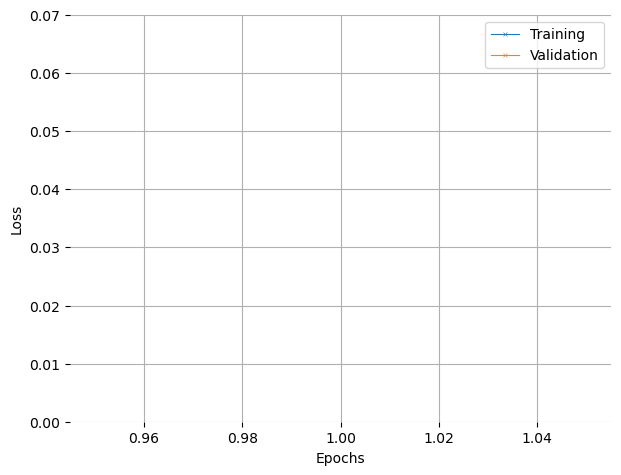

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, loss_values[start_by_epoch-1:], label='Training Loss', marker='x', markersize=2.5, mew=0.4, linewidth=0.8)
plt.plot(epochs, val_loss_values[start_by_epoch-1:], label='Validation Loss', marker='x', markersize=2.5, mew=0.4, linewidth=0.8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid()
ax = plt.gca()
plt.tight_layout()
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0,0.07)
# plt.savefig('D:/results/CICIoT2023/figures/[CICIoT2023] [CNN] Multiclass classification loss.eps', format='eps', dpi=1200)
plt.show()
plt.clf()

In [ ]:
start_time = time.time()
pred = model.predict(X_val)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

inference_time_np = np.array([['Start time', 'End time', 'Inference time'],
                            [start_time, end_time, inference_time]])

 64980/175853 [==========>...................] - ETA: 3:45

In [ ]:
# Convert predictions classes to one hot vectors 
pred = np.argmax(pred,axis=1)
# Convert validation observations to one hot vectors
y_test = Y_test.argmax(axis=1)

print(pred.shape)
print(y_test.shape)

score = metrics.accuracy_score(y_test, pred)
rscore = recall_score(y_test, pred, average='weighted')
ascore = precision_score(y_test, pred, average='weighted')
ascore_macro = precision_score(y_test, pred, average='macro')
f1score= f1_score(y_test, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

print("Validation score: {}".format(score))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("Precision score macro: {}".format(ascore_macro))
print("F1 Measure score: {}".format(f1score))

(9003649,)
(9003649,)


c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation score: 0.7803431697526192
Recall score: 0.7803431697526192
Precision score: 0.7889050283393315
Precision score macro: 0.6736301267567226
F1 Measure score: 0.76232291330802
